# NLP node 6. 임베딩과 편향

In [9]:
import numpy as np
from numpy import dot
from numpy.linalg import norm
import os


In [31]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev



In [11]:
from konlpy.tag import Okt
okt = Okt()
tokenized = []
with open('synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

In [12]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  

In [13]:
model.wv.most_similar(positive=['사랑'])

[('아르튬', 0.7054110765457153),
 ('애정', 0.7001467347145081),
 ('행복', 0.6941739916801453),
 ('첫사랑', 0.6918733716011047),
 ('이별', 0.6852905750274658),
 ('진심', 0.6824775338172913),
 ('연애', 0.681338369846344),
 ('만남', 0.6804609298706055),
 ('우정', 0.6764481067657471),
 ('가슴', 0.6672431230545044)]

word embedding의 결과가 제대로 된 것 같습니다.

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

print("슝~")

슝~


In [15]:
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [37]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

In [38]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 


In [39]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [40]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [23]:
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [41]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


# 장르별 단어 셋의 선정 :
node에서는 상위 15개를 선정해서 사용하였지만 여기서는 중복 제외하고 15개를 담도록 고치겠습니다.

In [42]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 100): #store 100 words for each genre.
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 외계, 존재, 세상, 발견, 행성, 정체, 친구, 비밀, 사실, 기억, 전쟁, 사건, 시간, 공격, 영화, 한편, 실험, 능력, 시스템, 위협, 생명체, 정부, 아들, 사고, 스타크, 리플리, 과학자, 음모, 파괴, 아버지, 켈빈, 컨트, 모두, 수퍼맨, 임무, 발생, 가족, 요원, 죽음, 다시, 위기, 과거, 외계인, 도시, 이제, 갑자기, 상황, 운명, 분파, 불명, 연구, 개발, 때문, 탈출, 명의, 의문, 남자, 아이, 현실, 바이러스, 상어, 물체, 진화, 목숨, 최후, 통해, 프로젝트, 수트, 생존, 과연, 사랑, 히노키, 섹터, 미국, 여행, 대원, 멸망, 조직, 바로, 위험, 사이, 세력, 감염, 괴물, 거대, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 할머니, 씨제이, 동구, 사랑, 아이, 사람, 학교, 세상, 소년, 슈이트, 이야기, 가장, 어머니, 마갈, 소녀, 미아, 대한, 펠리칸, 모두, 혼자, 서울, 벤트, 케이시, 마음, 사건, 할아버지, 엠마, 고양이, 크리스마스, 아내, 사이, 최호, 요정, 모험, 혜지, 유나, 테리, 위기, 다시, 번개, 손녀, 그레고리, 과연, 결심, 시골, 파코, 작품, 영화, 스튜어트, 해나, 인형, 단편, 기억, 발견, 서로, 하나, 한편, 부산, 아스, 장난감, 도시, 크누드, 누키, 제노, 아기, 때문, 이자, 펠릭스, 노동자, 회사, 생각, 사실, 마르, 주니, 강아지, 간다, 다른, 소식, 시간, 신차, 잉그릿, 제페토, 규완, 우산, 도움, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 카르피, 비바, 왕자, 콘서트, 백작부인, 반니, 아리아, 미노, 차이코프스키, 라다, 무대, 도시, 공작, 리코, 시작, 파우스트, 메스,

In [43]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

# 중복 제거 :
장르별로 100개의 대표 단어를 일단 저장하였는데, 예술 - 상업 영화에서 한 것과 같은 방식으로 중복되지 않은 것들을 골라냅니다. 

In [49]:
n = 15
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        
        attr_a=[]
        attr_b=[]
        for k in range(100):
            if (attributes[i][k] not in attributes[j]) and (attributes[i][k] in model.wv): attr_a.append(attributes[i][k])
            if len(attr_a) == n: break 

        for k in range(100):
            if (attributes[j][k] not in attributes[i]) and (attributes[j][k] in model.wv): attr_b.append(attributes[j][k])
            if len(attr_b) == n: break
                
        A = np.array([model.wv[word] for word in attr_a])
        B = np.array([model.wv[word] for word in attr_b])
        
        matrix[i][j] = weat_score(X, Y, A, B)

In [50]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

SF 가족 -0.21551062
SF 공연 0.0072324853
SF 공포(호러) -0.555869
SF 기타 0.33753997
SF 다큐멘터리 0.50848556
SF 드라마 -0.2994979
SF 멜로로맨스 -0.7239382
SF 뮤지컬 0.46259475
SF 미스터리 -0.5858393
SF 범죄 -0.37414932
SF 사극 0.0910645
SF 서부극(웨스턴) -0.29078913
SF 성인물(에로) -0.5530829
SF 스릴러 -0.60819066
SF 애니메이션 0.36761943
SF 액션 -0.5421889
SF 어드벤처 -0.035481773
SF 전쟁 0.31094047
SF 코미디 -0.30259925
SF 판타지 -0.13451056
가족 공연 0.337527
가족 공포(호러) 0.07687596
가족 기타 0.9531455
가족 다큐멘터리 0.84190136
가족 드라마 0.7421489
가족 멜로로맨스 -0.4825282
가족 뮤지컬 0.67946225
가족 미스터리 -0.14469106
가족 범죄 0.33721992
가족 사극 0.22297709
가족 서부극(웨스턴) 0.10980501
가족 성인물(에로) -0.5471248
가족 스릴러 -0.24198331
가족 애니메이션 0.929924
가족 액션 -0.052600883
가족 어드벤처 0.53813887
가족 전쟁 0.617997
가족 코미디 0.4819891
가족 판타지 0.762836
공연 공포(호러) -0.35342324
공연 기타 0.7232487
공연 다큐멘터리 0.66830605
공연 드라마 -0.28823668
공연 멜로로맨스 -0.6421547
공연 뮤지컬 1.221847
공연 미스터리 -0.34356567
공연 범죄 -0.15369013
공연 사극 -0.28119895
공연 서부극(웨스턴) 0.053173773
공연 성인물(에로) -0.5249728
공연 스릴러 -0.38285968
공연 애니메이션 0.7237237
공연 액션 -0.29080233

<AxesSubplot:>

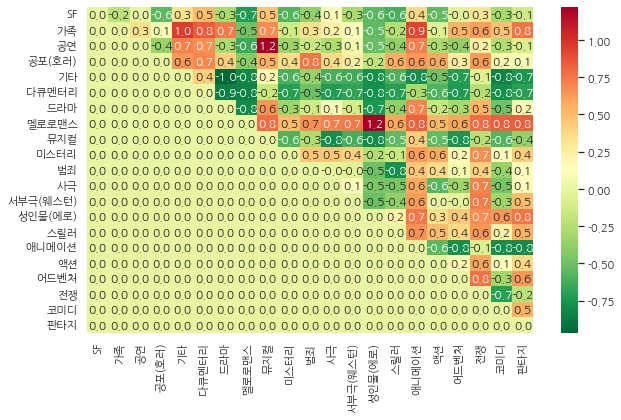

In [62]:
import numpy as np; 
import seaborn as sns; 
import matplotlib.pyplot as plt

np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(10,6))
ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True, fmt='.1f',  cmap='RdYlGn_r')
ax

# 결과, 돌아보기
마지막 결과에서 두 개를 비교했을때 어느 것이 예술영화에 가깝고, 어느 것이 상업영화에 가까운지 알 수 있습니다.
양의 숫자가 크게 나오면, x축에 있는 장르가 y축의 장르보다 상업영화에 가깝다는 뜻입니다.
음의 숫자가 크게 나오면, x축에 있는 장르가 y축의 장르보다 예술영화에 가깝다는 뜻입니다.  

액션 장르는 대표적인 상업영화 장르입니다. 하지만 뚜렷한 경향성을 보이지 않습니다.
그런데 노드에서 멜로로맨스가 코미디, 전쟁 영화와 비교해서 예술영화에 가깝다고 하여 큰 혼란을 느꼈습니다. 영화에 별로 관심이 없어서 그런지 몰랐습니다. 대체 어떻게 분석을 할 수 있을까요? 코미디와 전쟁을 비교하면 코미디가 훨씬 음수가 많아서 더 예술영화에 가깝다고 할 수 있겠습니다. 코미디-전쟁의 경우 상당히 큰 음수값이 나왔는데 제대로 해석하고 있는 거라면 전쟁영화보다 코미디 영화가 예술영화와 유사하다는 뜻입니다. 이렇게 보면 경향성은 맞지만, 

여기서 대표 단어의 문제를 가정할 수 있습니다. 절대값이 가장 크게 나온 경우를 살펴보면 멜로로맨스 - 성인물(에로) 사이에서 나타났습니다. 공연 - 뮤지컬에서도 마찬가지였습니다. 혹시 장르를 잘 대표하는 단어들이 이런 경우 중복돼서 무시된 것이 아닐까요? 그렇다면 상대적으로 예술, 상업영화 같은 다른 특징이 두드러지게 될 수도 있겠습니다.